In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from matplotlib import pyplot as plt
from patsy import dmatrix

import causalpy as cp

## Setting for Mac OS spawning multi-process defaults on M1 chip
sampler_kwargs = {"tune": 2000, "draws": 2000, "target_accept": 0.95, "mp_ctx": "spawn"}

## The Pardox of Propensity Scores in Bayesian Inference

In causal inference the role of the propensity score is often seen to be central. We've seen how the propensity score can be used with the `cp.InversePropensityWeighting` class to correct for a species of selection bias by re-weighting our outcome variable and calculating a causal contrast on the re-weighted scale. Additionally we can use the propensity score to visualise and diagnose problems of overlap or covariate balancing across treatment and control groups. 

These properties give the propensity score a large role to play in _design based_ approaches to causal inference. The focus is on assessing aspects of the treatment allocation to ensure we have identifiability assurances for estimands of interest. 

When we use `cp.InversePropensityWeighting` to apply various re-weighting techniques we perform a two-step  manoeuvre: (1) we estimate the propensity score and (2) apply the inverse-weighting of the score to transform our outcome variable and assess causal contrasts. But being good Bayesians, we might wonder why go to all this trouble? Can we not simple estimate a full-bayesian model of treatment and outcome simultaneously?

In this notebook we'll show why we should be careful attempting to model the joint-distribution of the propensity score and the outcome variable, but still make good use of the propensity score. 

#### Brief Digression on the Mathematics

Consider that we have the following three variables:

$$ P(Y, T, X) $$ 

where $Y$ is our outcome variable, $T$ is our treatment variable, and $X$ stands in for all other control variables in scope. Now define the propensity score

$$ e(X) = P(T | X)$$

and our outcome model

$$ P(Y | T, X) = \dfrac{P(Y, T, X)}{P(T, X)}\cdot P(T, X) = \dfrac{P(Y | T, X) \cdot P(T | X) \cdot P(X)}{P(T | X) \cdot P(X)} P(T, X) = \dfrac{P(Y | T, X) \cdot e(X)\cdot P(X)}{e(X) \cdot P(X)} \cdot P(T, X) $$

but now it's clearer to see how the propensity score just cancels out. When we're already conditioning on $X, T$ the information in the propensity score is technically redundant in the Bayesian setting. Add the assumption of unconfoundedness or ignorability used in causal inference. We are arguing that there is no umeasured confounding so conditioning on $X, T$ should be sufficient to identify the causal contrast of interest. 

### Structure of the Presentation

We will first consider a simple simulated data set where we know the true values of the data generating process. We'll first demonstrate how to fit the joint distribution of the propensity score and the outcome in a single joint distribution using `PyMC`. Then we'll show how to fit a two-stage version of the same model. In both models we assume independent priors between the regression for the treatment and the regression for the outcome variable. Nevertheless, we will show that the joint model exhibits a bias due to feedback when there is non-measured confounding i.e. when there is misspecified outcome model. 

- Model Specification
    - Joint Model
    - 2 Stage Model
- Application to Simulated Outcome
- Application to Mosquito Net Data
- Application to Lalonde Data
- Application to NHEFS data.

Note the presentation here owes a debt to the work of Fan Li in {cite:p}`liBayesianProp` and her presentation [here](https://youtu.be/_BjkF2nl7dg?si=Pmza3EoTpz-flT8m&t=26). Additionally we drew on the work and data of Andrew Heiss [here](https://www.andrewheiss.com/blog/2021/12/18/bayesian-propensity-scores-weights/) and Jordan Nafa and Andrew Heiss [here](https://www.andrewheiss.com/blog/2021/12/20/fully-bayesian-ate-iptw/). 

#### Generate Some Data

In [2]:
N = 4000


def inv_logit(z):
    """Compute the inverse logit (sigmoid) of z."""
    return 1 / (1 + np.exp(-z))


df1 = pd.DataFrame(
    {
        "x1": np.random.normal(0, 1, N),
        "x2": np.random.normal(0, 1, N),
        "x3": np.random.normal(0, 1, N),
    }
)

TREATMENT_EFFECT = 2
df1["trt"] = np.random.binomial(1, inv_logit(df1["x1"] + 6 * df1["x2"] + 7 * df1["x3"]))
df1["outcome"] = (
    1
    + TREATMENT_EFFECT * df1["trt"]
    + df1["x1"]
    + 0.2 * df1["x2"]
    + -3 * df1["x3"]
    + np.random.normal(0, 1, N)
)


df1.head()

,x1,x2,x3,trt,outcome
0,-2.068881,-0.350503,-0.621765,0,0.235686
1,-1.148622,-0.940770,0.558237,0,-3.428762
2,-0.879276,-1.126818,-0.337692,0,0.719894
3,0.025526,0.133489,-1.485594,0,5.725299
4,0.687656,0.494313,1.816960,1,-1.476772


### Specifying the Joint Model

Here we will define a model context that fits our data simultaneously for treatment and outcome. We allow that the propensity score estimated in the treatment model is used in a non-parametric spline to flexibly inform the outcome variable. Note that we will allow for a richer model specification of the treatment than we do for the outcome model. This is to try and push the models to use the propensity score information to adjust for unmeasured confounding in the outcome model. 

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


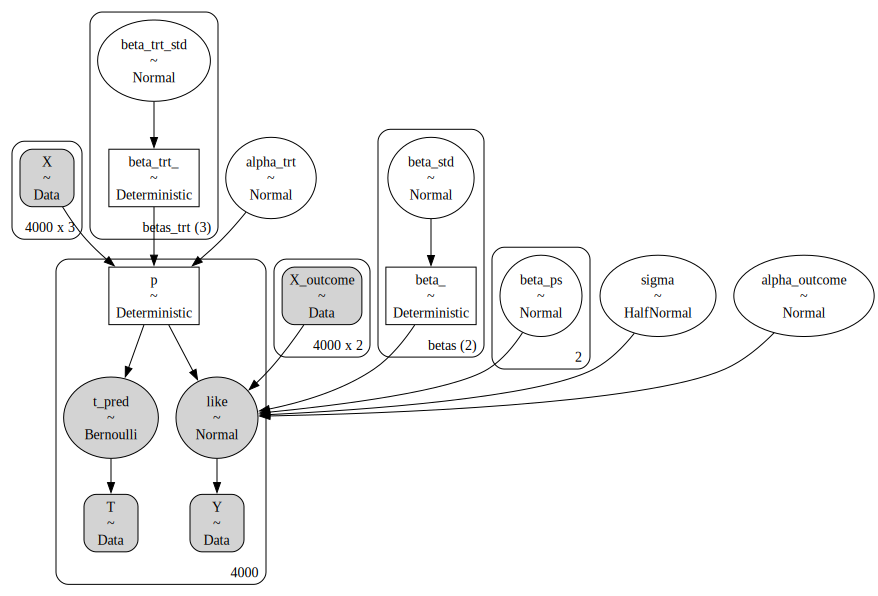

In [3]:
coords = {
    "betas": ["trt", "x1"],
    "betas_trt": ["x1", "x2", "x3"],
    "obs": range(df1.shape[0]),
}

N = df1.shape[0]
X_trt = df1[["x1", "x2", "x3"]].values
X_outcome = df1[["trt", "x1"]].values
T_data = df1["trt"].values
Y_data = df1["outcome"].values


def make_model(
    X_trt,
    X_outcome,
    T_data,
    Y_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
        "sigma": 1,
    },
    noncentred=True,
    normal_outcome=True,
):
    with pm.Model(coords=coords) as model:
        X_data_trt = pm.Data("X", X_trt)
        X_data_outcome = pm.Data("X_outcome", X_outcome)
        T_data_ = pm.Data("T", T_data, mutable=True)
        Y_data_ = pm.Data("Y", Y_data)

        if noncentred:
            mu_beta_trt, sigma_beta_trt = priors["beta_trt"]
            beta_trt_std = pm.Normal("beta_trt_std", 0, 1, dims="betas_trt")
            beta_trt = pm.Deterministic(
                "beta_trt_",
                mu_beta_trt + sigma_beta_trt * beta_trt_std,
                dims="betas_trt",
            )

            mu_beta, sigma_beta = priors["beta_"]
            beta_std = pm.Normal("beta_std", 0, 1, dims="betas")
            beta = pm.Deterministic(
                "beta_", mu_beta + sigma_beta * beta_std, dims="betas"
            )
        else:
            beta_trt = pm.Normal(
                "beta_trt_",
                priors["beta_trt"][0],
                priors["beta_trt"][1],
                dims="betas_trt",
            )

            beta = pm.Normal(
                "beta_", priors["beta_"][0], priors["beta_"][1], dims="betas"
            )

        beta_ps = pm.Normal("beta_ps", 0, 1, size=2)

        alpha_trt = pm.Normal(
            "alpha_trt", priors["alpha_trt"][0], priors["alpha_trt"][1]
        )
        mu_trt = alpha_trt + pm.math.dot(X_data_trt, beta_trt)
        p = pm.Deterministic("p", pm.math.invlogit(mu_trt))

        pm.Bernoulli("t_pred", p=p, observed=T_data_)

        alpha_outcome = pm.Normal(
            "alpha_outcome", priors["alpha_outcome"][0], priors["alpha_outcome"][1]
        )
        mu_outcome = (
            alpha_outcome
            + pm.math.dot(X_data_outcome, beta)
            + beta_ps[0] * p
            + beta_ps[1] * (p * T_data)
        )
        sigma = pm.HalfNormal("sigma", priors["sigma"])

        if normal_outcome:
            _ = pm.Normal("like", mu_outcome, sigma, observed=Y_data_)
        else:
            nu = pm.Exponential("nu", lam=1 / 10)
            _ = pm.StudentT("like", nu=nu, mu=mu_outcome, sigma=sigma)

    return model


model = make_model(X_trt, X_outcome, T_data, Y_data, coords)

pm.model_to_graphviz(model)

Note how the two likelihood terms are fit simultaneously. 

### Specifying the 2 Stage Model

Here we allow for a function that takes the same inputs but fits two separate models. First we fit the treatment model then store the `idata_treatment` this xarray object stores the posterior estimates for the propensity score. We pass this through to a second outcome model where we proceed to take a random draw from the posterior and pass it through to the outcome regression via a spline component. This allows us to express any non-linearity in the treatment effect. Additionally it can be seen as a way to augment the outcome model.

While theoretically the propensity score contains no extra information if we are already conditioning on $X$, practically the literature reports that the propensity improves the stability of the causal estimates achievable in Bayesian causal modelling. Additionally we might want to separate covariates for predicting the outcome and the treatment. In this case, there may be extra information derived in the treatment model that be used to inform the outcome model. 

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


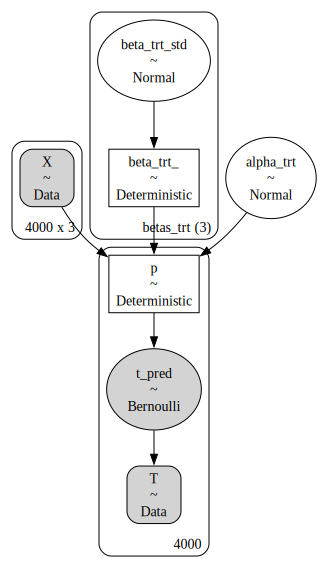

In [4]:
def make_treatment_model(
    X_trt,
    T_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
    },
    noncentred=True,
):
    with pm.Model(coords=coords) as model_trt:
        X_data_trt = pm.Data("X", X_trt)
        T_data_ = pm.Data("T", T_data, mutable=True)

        if noncentred:
            mu_beta_trt, sigma_beta_trt = priors["beta_trt"]
            beta_trt_std = pm.Normal("beta_trt_std", 0, 1, dims="betas_trt")
            beta_trt = pm.Deterministic(
                "beta_trt_",
                mu_beta_trt + sigma_beta_trt * beta_trt_std,
                dims="betas_trt",
            )

        else:
            beta_trt = pm.Normal(
                "beta_trt_",
                priors["beta_trt"][0],
                priors["beta_trt"][1],
                dims="betas_trt",
            )

        alpha_trt = pm.Normal(
            "alpha_trt", priors["alpha_trt"][0], priors["alpha_trt"][1]
        )
        mu_trt = alpha_trt + pm.math.dot(X_data_trt, beta_trt)
        p = pm.Deterministic("p", pm.math.invlogit(mu_trt))

        pm.Bernoulli("t_pred", p=p, observed=T_data_)
    return model_trt


def make_outcome_model(
    X_outcome,
    Y_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
        "sigma": 1,
    },
    noncentred=True,
    spline_component=False,
    propensity_score_idata=None,
    normal_outcome=True,
):
    propensity_scores = az.extract(propensity_score_idata)["p"]
    with pm.Model(coords=coords) as model_outcome:
        X_data_outcome = pm.Data("X_outcome", X_outcome)
        Y_data_ = pm.Data("Y", Y_data)

        if noncentred:
            mu_beta, sigma_beta = priors["beta_"]
            beta_std = pm.Normal("beta_std", 0, 1, dims="betas")
            beta = pm.Deterministic(
                "beta_", mu_beta + sigma_beta * beta_std, dims="betas"
            )
        else:
            beta = pm.Normal(
                "beta_", priors["beta_"][0], priors["beta_"][1], dims="betas"
            )

        beta_ps = pm.Normal("beta_ps", 0, 1, size=2)

        chosen = np.random.choice(range(propensity_scores.shape[1]))
        p = propensity_scores[:, chosen].values

        alpha_outcome = pm.Normal(
            "alpha_outcome", priors["alpha_outcome"][0], priors["alpha_outcome"][1]
        )
        mu_outcome = (
            alpha_outcome
            + pm.math.dot(X_data_outcome, beta)
            + beta_ps[0] * p
            + beta_ps[1] * (p * T_data)
        )

        if spline_component:
            beta_ps_spline = pm.Normal("beta_ps_spline", 0, 1, size=34)
            B = dmatrix(
                "bs(ps, knots=knots, degree=3, include_intercept=True, lower_bound=0, upper_bound=1) - 1",
                {"ps": p, "knots": np.linspace(0, 1, 30)},
            )
            B_f = np.asarray(B, order="F")
            splines_summed = pm.Deterministic(
                "spline_features", pm.math.dot(B_f, beta_ps_spline.T)
            )
            mu_outcome = mu_outcome + splines_summed

        sigma = pm.HalfNormal("sigma", priors["sigma"])

        if normal_outcome:
            _ = pm.Normal("like", mu_outcome, sigma, observed=Y_data_)
        else:
            nu = pm.Exponential("nu", lam=1 / 10)
            _ = pm.StudentT("like", nu=nu, mu=mu_outcome, sigma=sigma)

    return model_outcome


def make_2step_model(
    X_trt,
    X_outcome,
    T_data,
    Y_data,
    coords,
    priors,
    spline_component=False,
    normal_outcome=True,
):
    treatment_model = make_treatment_model(X_trt, T_data, coords, priors)
    with treatment_model:
        idata_treatment = pm.sample_prior_predictive()
        idata_treatment.extend(pm.sample(**sampler_kwargs))

    outcome_model = make_outcome_model(
        X_outcome,
        Y_data,
        coords,
        priors,
        spline_component,
        propensity_score_idata=idata_treatment,
        normal_outcome=normal_outcome,
    )
    with outcome_model:
        idata_outcome = pm.sample_prior_predictive()
        idata_outcome.extend(pm.sample(**sampler_kwargs))

    return idata_treatment, idata_outcome, treatment_model, outcome_model


model_treatment = make_treatment_model(X_trt, T_data, coords)

pm.model_to_graphviz(model_treatment)

### Putting it all Together

We are now in a position to fit both joint and modular (2-stage) models to our simulated data. We are seeking to assess how the different approaches to incorporating propensity score information impacts the accuracy of the treatment effect estimate. 

In [5]:
priors = {
    "beta_": [0, 1],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [0, 1],
    "sigma": 1,
}

joint_model = make_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

with joint_model:
    idata_joint = pm.sample(**sampler_kwargs)

(
    idata_treatment_2s_joint,
    idata_outcome_2s_joint,
    treatment_model_joint,
    outcome_model_joint,
) = make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors)

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, beta_std, beta_ps, alpha_trt, alpha_outcome, sigma]


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 85 seconds.
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
Sampling: [alpha_outcome, beta_, beta_ps, like, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_, beta_ps, alpha_outcome, sigma]


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.


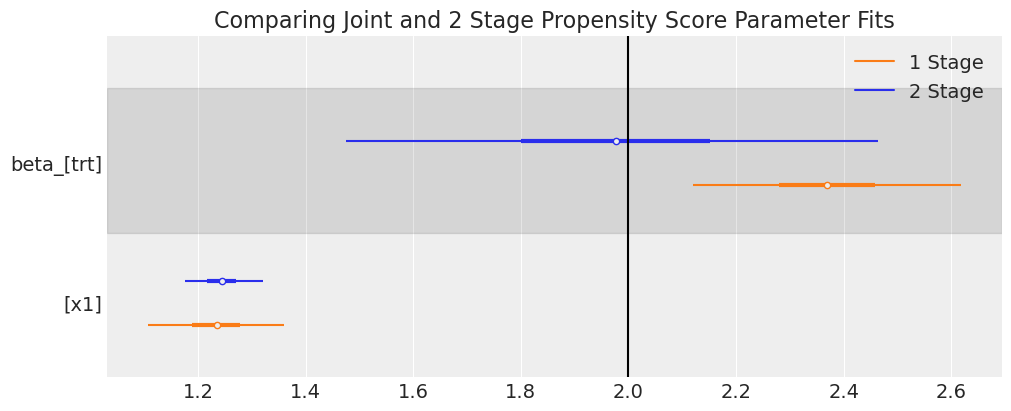

In [6]:
ax = az.plot_forest(
    [idata_outcome_2s_joint, idata_joint],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].axvline(2, label="True Treatment Value", color="k")
ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

In [7]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_joint, var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_joint, var_names=["beta_", "alpha_outcome"]
        ),
    }
)
compare_estimate[["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]]

mean     sd  hdi_3%  hdi_97%  r_hat
1-stage-model alpha_trt      -0.012  0.025  -0.058    0.037    1.0
              beta_[trt]      2.371  0.133   2.119    2.618    1.0
              beta_[x1]       1.235  0.067   1.107    1.360    1.0
              beta_ps[0]    -14.669  0.294 -15.217  -14.112    1.0
              beta_ps[1]     -0.060  0.240  -0.502    0.407    1.0
              alpha_outcome   8.132  0.149   7.855    8.411    1.0
2-stage-model beta_[trt]      1.976  0.260   1.476    2.464    1.0
              beta_[x1]       1.245  0.039   1.175    1.320    1.0
              alpha_outcome   3.107  0.060   2.991    3.220    1.0

Here the models fail to recover substantially similar and correct results. This is interesting and demonstrates a key property of propensity scores in the Bayesian setting. 

### The Problem of Feedback

The issue here is sometimes called Bayesian feedback or "collider bias via the likelihood", and it's a key issue when trying to build joint models for causal inference in the Bayesian paradigm. Because we have fit the outcome and the treatment models simultaneously, and this means that the outcome can influence the posterior distribution of the parameters $\beta$ in the treatment model and it violates the idea of design-before-analysis. We have here an apparent example of a slight bias due to this effect.  The two stage modular approach seems to better recover the treatment effect reported in the literature and avoids the risk of collider bias i.e. in the modular implementation we are able to use the propensity score to adjust for accuracy and compensate for the missing variables `x2` and `x1`. 


**💡 Key Take-away:** With an underspecified outcome model, we may use a well specified propensity score for adjusting the model to retrieve accurate treatment effect estimates. However, this tends to breakdown if we have estimated both propensity score and outcome in a joint bayesian model due to feedback effects. The solution is to use the propensity score in a 2 stage fashion. 


#### Propensity Score Quantiles - Joint Model

We can see how the different model specifications have yielded distinct propensity score estimates - as the joint specification seems to compensate for missing covariates in the outcome model by adjusting the propensity score latent in the treatment model too. We can see the differences in the quantiles to highlight a numeric difference in the propensity score distributions between the two models.

In [8]:
idata_joint["posterior"]["p"].quantile(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
).round(3)

<xarray.DataArray 'p' (quantile: 9)> Size: 72B
array([0.22 , 0.298, 0.369, 0.433, 0.491, 0.553, 0.619, 0.695, 0.78 ])
Coordinates:
  * quantile  (quantile) float64 72B 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9

#### Propensity Score Quantiles - 2 Stage Modular Model

The range an position of these quantiles is vastly different than the joint model specification. 

In [9]:
idata_treatment_2s_joint["posterior"]["p"].quantile(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
).round(3)

<xarray.DataArray 'p' (quantile: 9)> Size: 72B
array([0.   , 0.002, 0.016, 0.107, 0.495, 0.864, 0.978, 0.999, 1.   ])
Coordinates:
  * quantile  (quantile) float64 72B 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9

### Causal Estimate with Do-Operator

We can also confirm the model implications through counterfactual imputation. This ties the Bayesian setting back the potential outcomes framework. The fundamental problem of causal inference, when seen as a missing data problem allows us to derive causal estimands through imputation of the potential outcomes. Here we "push forward" the posterior predictive distribution for $Y$ under different treatment settings. 

In [10]:
X_outcome_trt = X_outcome.copy()
X_outcome_trt[:, 0] = 1

X_outcome_ntrt = X_outcome.copy()
X_outcome_ntrt[:, 0] = 0

First we specify our counterfactual input data. Then we push them through the joint model distribution using the do-operator in `PyMC` to sample from the posterior predictive distribution giving us sample of the potential outcomes $Y(1), Y(0)$

In [11]:
with pm.do(
    joint_model,
    {"T": np.ones(len(df1), dtype=np.int32), "X_outcome": X_outcome_trt},
    prune_vars=True,
) as treatment_model:
    idata_trt = pm.sample_posterior_predictive(idata_joint, var_names=["like", "p"])

with pm.do(
    joint_model,
    {"T": np.zeros(len(df1), dtype=np.int32), "X_outcome": X_outcome_ntrt},
    prune_vars=True,
) as ntreatment_model:
    idata_ntrt = pm.sample_posterior_predictive(idata_joint, var_names=["like", "p"])

Sampling: [like]


Output()

Sampling: [like]


Output()

For sake of illustration we calculate the mean value for $Y(1)$

In [12]:
idata_trt["posterior_predictive"]["like"].mean()

<xarray.DataArray 'like' ()> Size: 8B
array(3.24011481)

The mean value for $Y(0)$

In [13]:
idata_ntrt["posterior_predictive"]["like"].mean()

<xarray.DataArray 'like' ()> Size: 8B
array(0.86890385)

and their difference, which is the causal estimand of interest.

In [14]:
(
    idata_trt["posterior_predictive"]["like"].mean()
    - idata_ntrt["posterior_predictive"]["like"].mean()
)

<xarray.DataArray 'like' ()> Size: 8B
array(2.37121096)

In this way we can impute potential outcomes gain insight into any variety of causal estimands we care to calculate. In this case we can see what we derived above that the joint model yields a biased treatment effect estimate. 

### Comparing Propensity Score Skew

We have seen how the treatment effect reported by both models differ and that the joint model exhibits a bias away from the true treatment effect. But we might want to see how this bias manifests in the propensity score distribution. 

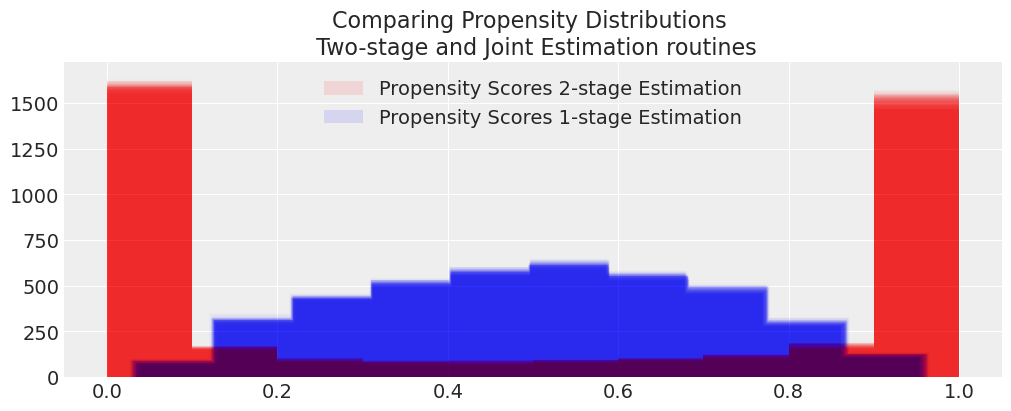

In [15]:
def compare_prop_dists(idata_2s, idata_1s):
    fig, ax = plt.subplots(figsize=(10, 4))
    for i in range(100):
        s2 = idata_2s["posterior"].stack(z=("chain", "draw"))["p"][:, i]
        s1 = idata_1s["posterior"].stack(z=("chain", "draw"))["p"][:, i]
        if i == 0:
            ax.hist(
                s2, alpha=0.1, color="red", label="Propensity Scores 2-stage Estimation"
            )
            # Pivoted to compare shape
            ax.hist(
                1 - s1,
                alpha=0.1,
                color="blue",
                label="Propensity Scores 1-stage Estimation",
            )
        else:
            ax.hist(s2, alpha=0.01, color="red")
            # Pivoted to compare shape
            ax.hist(1 - s1, alpha=0.01, color="blue")
    ax.legend()
    ax.set_title(
        "Comparing Propensity Distributions \n Two-stage and Joint Estimation routines"
    )


compare_prop_dists(idata_treatment_2s_joint, idata_joint)

These are radically different models due to the feedback mechanism. How does this phenomena play out in some real world examples?

### Nets Example

Next we'll asses a data set used by Andrew Heiss to demonstrate propensity score methods with `brms`. 

In [16]:
nets_df = cp.load_data("nets")
nets_df["trt"] = nets_df["net_num"]
nets_df["outcome"] = nets_df["malaria_risk"]
nets_df

,id,net,net_num,malaria_risk,income,health,household,eligible,temperature,resistance,trt,outcome
0,1,True,1,33,781,56,2,False,21.1,59,1,33
1,2,False,0,42,974,57,4,False,26.5,73,0,42
2,3,False,0,80,502,15,3,False,25.6,65,0,80
3,4,True,1,34,671,20,5,True,21.3,46,1,34
4,5,False,0,44,728,17,5,False,19.2,54,0,44
...,...,...,...,...,...,...,...,...,...,...,...,...
1747,1748,True,1,18,961,27,4,False,22.1,27,1,18
1748,1749,False,0,49,906,49,5,False,30.7,55,0,49
1749,1750,False,0,17,1325,92,2,False,21.4,52,0,17
1750,1751,False,0,46,879,33,6,False,27.4,62,0,46


In [17]:
coords = {
    "betas": ["trt", "income"],
    "betas_trt": ["income", "temperature", "health"],
    "obs": range(nets_df.shape[0]),
}

# Process and Standardise Inputs
N = nets_df.shape[0]
X_trt = nets_df[["income", "temperature", "health"]].values
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)
X_outcome = nets_df[["trt", "income"]].values
X_outcome = (X_outcome - X_outcome.mean(axis=0)) / X_outcome.std(axis=0)
T_data = nets_df["trt"].values
X_outcome[:, 0] = T_data
Y_data = nets_df["outcome"].values

priors = {
    "beta_": [0, 1],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [40, 30],
    "sigma": 15,
}
net_model = make_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

with net_model:
    idata_net = pm.sample(tune=2000, target_accept=0.98)

idata_treatment_2s_net, idata_outcome_2s_net, treatment_model_net, outcome_model_net = (
    make_2step_model(
        X_trt,
        X_outcome,
        T_data,
        Y_data,
        coords,
        priors=priors,
    )
)

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, beta_std, beta_ps, alpha_trt, alpha_outcome, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 13 seconds.
Sampling: [alpha_outcome, beta_, beta_ps, like, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_, beta_ps, alpha_outcome, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.


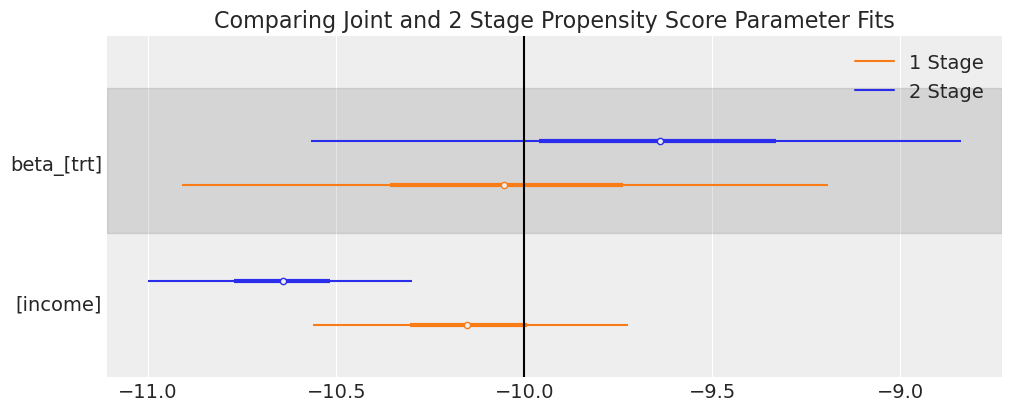

In [18]:
ax = az.plot_forest(
    [idata_outcome_2s_net, idata_net],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].axvline(-10, label="True Treatment Value", color="k")
ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

As before we have used both model specifications to derive estimates for the treatment effect. In this case we have allowed the outcome model access to only a single `income` predictor. And while both models seem to approximtely recover the reported -10 treatment estimate with a large degree of uncertainty. The modular 2 stage estimates pulls away from the joint model estimate.  

In [19]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_net, var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_net, var_names=["beta_", "alpha_outcome", "beta_ps"]
        ),
    }
)
compare_estimate[["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]]

mean     sd  hdi_3%  hdi_97%  r_hat
1-stage-model alpha_trt      -0.260  0.051  -0.357   -0.168    1.0
              beta_[trt]    -10.048  0.461 -10.911   -9.192    1.0
              beta_[income] -10.148  0.226 -10.561   -9.723    1.0
              beta_ps[0]    -16.308  0.709 -17.663  -14.996    1.0
              beta_ps[1]      0.179  0.864  -1.389    1.816    1.0
              alpha_outcome  46.732  0.419  45.947   47.526    1.0
2-stage-model beta_[trt]     -9.647  0.462 -10.567   -8.839    1.0
              beta_[income] -10.645  0.188 -11.001  -10.300    1.0
              alpha_outcome  42.281  0.416  41.500   43.058    1.0
              beta_ps[0]     -7.014  0.942  -8.859   -5.304    1.0
              beta_ps[1]     -1.279  0.881  -2.882    0.402    1.0

This kind of difference need not be very concerning but we should check if the bias stems from a difference in latent propensity scores as before. 

In [20]:
idata_net["posterior"]["p"].quantile(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
).round(3)

<xarray.DataArray 'p' (quantile: 9)> Size: 72B
array([0.181, 0.249, 0.31 , 0.37 , 0.43 , 0.501, 0.572, 0.643, 0.728])
Coordinates:
  * quantile  (quantile) float64 72B 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9

The quantiles of the propensity distributions across both models seem different. 

In [21]:
idata_treatment_2s_net["posterior"]["p"].quantile(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
).round(3)

<xarray.DataArray 'p' (quantile: 9)> Size: 72B
array([0.238, 0.282, 0.317, 0.348, 0.379, 0.412, 0.449, 0.492, 0.556])
Coordinates:
  * quantile  (quantile) float64 72B 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9

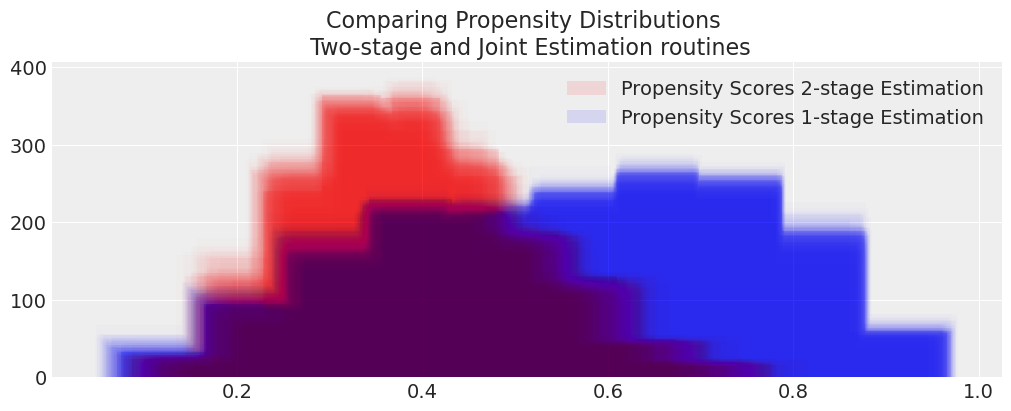

In [22]:
compare_prop_dists(idata_treatment_2s_net, idata_net)

Here we some divergence between the treatment effect estimates indicating that the regression adjustment approach in the 2 stage outcome model is correcting for bias in the joint-distribution. However both credible intervals contain the reported treatment effect of -10 so the skew is perhaps less concerning. This is despite the fact that we removed useful predictors `temperature`, `health` from the outcome model specification. The model leans on the information contained in the propensity score and weights the `beta_ps` information appropriately. 

### LaLonde Example

The Lalonde Data set is famous because it highlights a problem with naive causal contrasts. It is discussed by Angrist and Pischke in their _Mostly Harmless Econometrics_ as an example of how regression controls can tolerably address selection effects in a way similar to propensity score weighting. So we should hope the a well specified outcome model can identify the treatment effects plausibly here too. 

In [23]:
lalonde = df = cp.load_data("lalonde")
lalonde[["hispan", "white"]] = pd.get_dummies(lalonde["race"], drop_first=True)
lalonde.dropna(inplace=True)
lalonde.head()

,rownames,treat,age,educ,race,married,nodegree,re74,re75,re78,hispan,white
0,NSW1,1,37,11,black,1,1,0.0,0.0,9930.0460,False,False
1,NSW2,1,22,9,hispan,0,1,0.0,0.0,3595.8940,True,False
2,NSW3,1,30,12,black,0,0,0.0,0.0,24909.4500,False,False
3,NSW4,1,27,11,black,0,1,0.0,0.0,7506.1460,False,False
4,NSW5,1,33,8,black,0,1,0.0,0.0,289.7899,False,False


In [24]:
lalonde.groupby("treat")["re78"].mean().diff()

treat
0           NaN
1   -635.026212
Name: re78, dtype: float64

The Naive group difference suggests a negative effect. Lets see how our two models work when we remove predictors from the propensity model?

In [25]:
coords = {
    "betas": ["treat", "age", "educ", "hispan", "white", "married", "nodegree"],
    "betas_trt": ["hispan", "white", "married", "nodegree"],
    "obs": range(lalonde.shape[0]),
}

N = lalonde.shape[0]
X_trt = lalonde[["hispan", "white", "married", "nodegree"]].astype(np.int32).values
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)

X_outcome = (
    lalonde[["treat", "age", "educ", "hispan", "white", "married", "nodegree"]]
    .astype(np.int32)
    .values
)
# X_outcome = (X_outcome - X_outcome.mean()) / X_outcome.std()
T_data = lalonde["treat"].values
Y_data = lalonde["re78"].values


priors = {
    "beta_": [0, 4000],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [2000, 500],
    "sigma": 500,
}

lalonde_model = make_model(
    X_trt, X_outcome, T_data, Y_data, coords, priors, noncentred=False
)

with lalonde_model:
    idata_lalonde = pm.sample(tune=5000)

(
    idata_treatment_2s_lalonde,
    idata_outcome_2s_lalonde,
    treatment_model_lalonde,
    outcome_model_lalonde,
) = make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_, beta_, beta_ps, alpha_trt, alpha_outcome, sigma]


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 9 seconds.
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 11 seconds.
Sampling: [alpha_outcome, beta_, beta_ps, like, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_, beta_ps, alpha_outcome, sigma]


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 14 seconds.


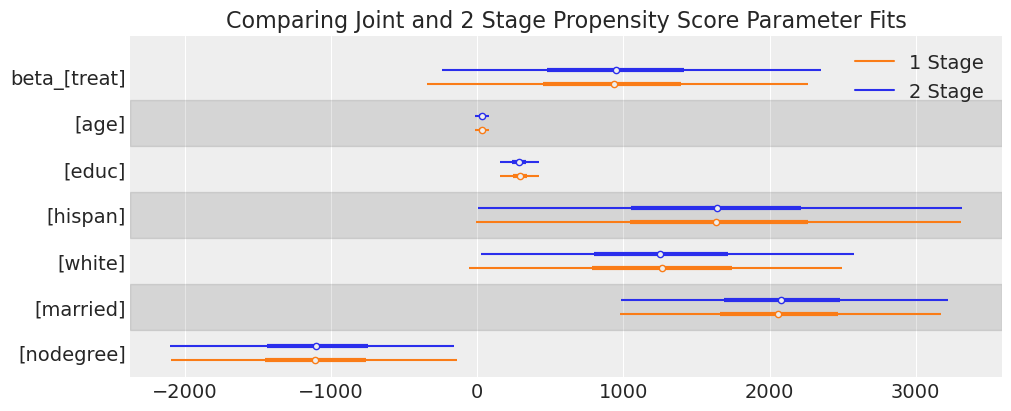

In [26]:
ax = az.plot_forest(
    [idata_outcome_2s_lalonde, idata_lalonde],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

In [27]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_lalonde,
            var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome", "sigma"],
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_lalonde,
            var_names=["beta_", "beta_ps", "alpha_outcome", "sigma"],
        ),
    }
)
compare_estimate[["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]]

mean       sd    hdi_3%   hdi_97%  r_hat
1-stage-model alpha_trt          -1.333    0.137    -1.578    -1.072    1.0
              beta_[treat]      926.915  692.921  -345.103  2259.967    1.0
              beta_[age]         30.099   25.814   -18.420    77.649    1.0
              beta_[educ]       290.983   71.761   157.873   421.534    1.0
              beta_[hispan]    1650.245  895.241    -9.516  3311.423    1.0
              beta_[white]     1256.242  683.217   -58.962  2497.228    1.0
              beta_[married]   2065.057  587.627   974.308  3175.766    1.0
              beta_[nodegree] -1103.199  516.867 -2098.378  -136.237    1.0
              beta_ps[0]         -0.000    1.002    -1.877     1.882    1.0
              beta_ps[1]          0.002    1.050    -1.964     1.974    1.0
              alpha_outcome    1786.561  491.016   847.880  2652.520    1.0
              sigma            6439.256  146.914  6176.871  6721.663    1.0
2-stage-model beta_[treat]      948.588  691.081  -239.413  2351.645    1.0
              beta_[age]         30.326   25.333   -18.342    78.132    1.0
              beta_[educ]       287.274   71.154   156.950   425.099    1.0
              beta_[hispan]    1635.510  875.386     5.781  3317.593    1.0
              beta_[white]     1255.931  680.717    28.430  2576.112    1.0
              beta_[married]   2080.664  595.085   983.510  3221.950    1.0
              beta_[nodegree] -1095.913  517.034 -2101.728  -159.452    1.0
              beta_ps[0]          0.001    0.993    -1.895     1.824    1.0
              beta_ps[1]         -0.009    1.020    -1.946     1.890    1.0
              alpha_outcome    1805.474  480.786   920.168  2719.070    1.0
              sigma            6436.702  146.785  6161.338  6715.592    1.0

The model estimates are basically identical. We should expect mirrored propensity score distributions indicating that feedback wasn't an issue. The outcome model leaned primarily on the covariate profile $X$ to derive the treatment effect estimate. 

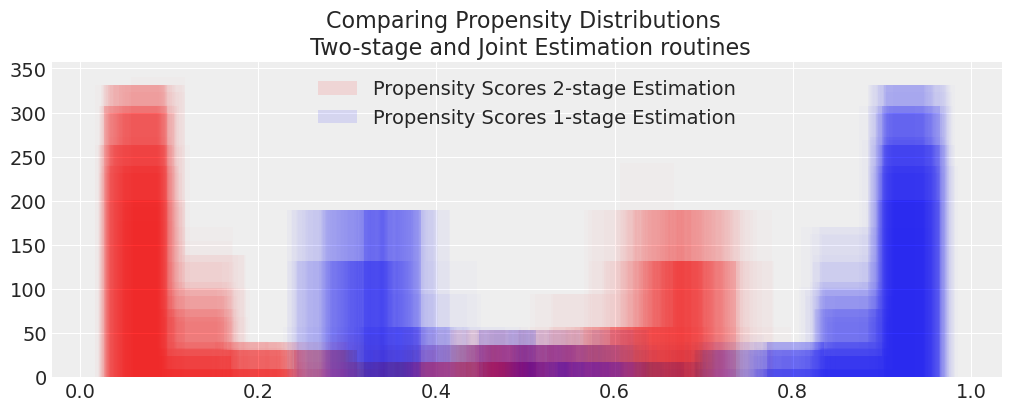

In [28]:
compare_prop_dists(idata_treatment_2s_lalonde, idata_lalonde)

Both estimates of the treatment effects accord well with values in the literature. We can be happy that both models are picking up on the treatment effects reasonably despite having a minimalist propensity score model. This is because in the Bayesian setting the conditional distribution of $X, T$ are generally sufficient when there is no unmeasured confounders. Here the model just ignores the propensity score coefficients `beta_ps`

### NHEFS 

Finally we turn to the NHEFS data. This data is known to be have a complex covariate profile for measuring aspects smokers health. We might suspect that there is some unmeasured confounding in this data set that would be hard to pick up on with simple regression controls. 

In [29]:
df = cp.load_data("nhefs")
df[["age", "race", "trt", "smokeintensity", "smokeyrs", "outcome"]].head()

,age,race,trt,smokeintensity,smokeyrs,outcome
0,42,1,0,30,29,-10.093960
1,36,0,0,20,24,2.604970
2,56,1,0,20,26,9.414486
3,68,1,0,3,53,4.990117
4,40,0,0,20,19,4.989251


In [30]:
coords = {
    "betas": ["trt", "age", "smokeintensity", "smokeyrs", "wt71"],
    "betas_trt": [
        "age",
        "race",
        "sex",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
        "age^2",
        "wt71^2",
        "smokeintensity^2",
        "smokeyrs^2",
    ],
    "obs": range(df.shape[0]),
}

N = df.shape[0]
X_trt = df[
    [
        "age",
        "race",
        "sex",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
        "age^2",
        "wt71^2",
        "smokeintensity^2",
        "smokeyrs^2",
    ]
]
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)
# Note the significantly reduced outcome model specification.
X_outcome = df[["trt", "age", "smokeintensity", "smokeyrs", "wt71"]]
X_outcome = (X_outcome - X_outcome.mean(axis=0)) / X_outcome.std(axis=0)
T_data = df["trt"].values
X_outcome["trt"] = T_data
Y_data = df["outcome"].values

priors = {
    "beta_": [0, 1],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [10, 5],
    "sigma": 7,
}

nhefs_model = make_model(X_trt, X_outcome, T_data, Y_data, coords, priors)
with nhefs_model:
    idata_nhefs = pm.sample(**sampler_kwargs)


(
    idata_treatment_2s_nhefs,
    idata_outcome_2s_nhefs,
    treatment_model_nhefs,
    outcome_model_nhefs,
) = make_2step_model(
    X_trt, X_outcome, T_data, Y_data, coords, priors=priors, spline_component=True
)

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, beta_std, beta_ps, alpha_trt, alpha_outcome, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 47 seconds.
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 36 seconds.
Sampling: [alpha_outcome, beta_ps, beta_std, like, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps, alpha_outcome, sigma]


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 14 seconds.


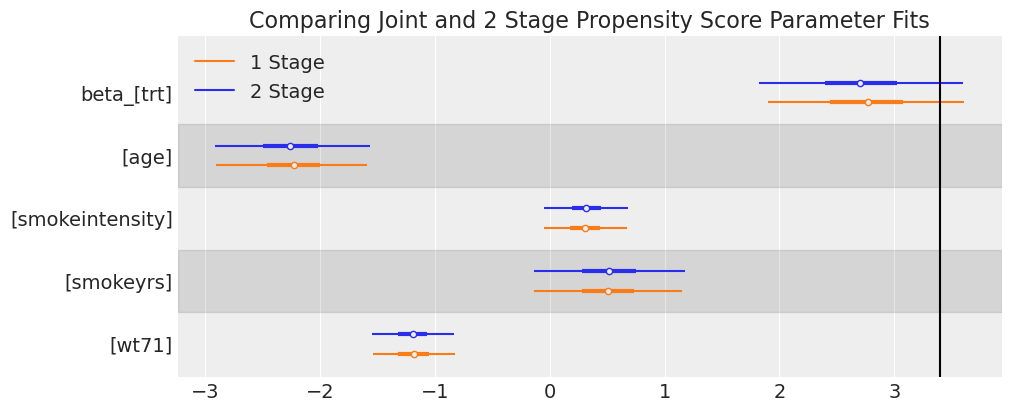

In [31]:
ax = az.plot_forest(
    [idata_outcome_2s_nhefs, idata_nhefs],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].axvline(3.4, label="True Treatment Value", color="k")
ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

Here we see the model specifications start to come apart. 

In [32]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_nhefs, var_names=["alpha_trt", "beta_", "alpha_outcome", "beta_ps"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_nhefs, var_names=["beta_", "alpha_outcome", "beta_ps"]
        ),
    }
)
compare_estimate[["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]]

mean     sd  hdi_3%  hdi_97%  r_hat
1-stage-model alpha_trt             -1.152  0.062  -1.276   -1.042    1.0
              beta_[trt]             2.761  0.458   1.901    3.608    1.0
              beta_[age]            -2.228  0.348  -2.905   -1.589    1.0
              beta_[smokeintensity]  0.308  0.193  -0.050    0.672    1.0
              beta_[smokeyrs]        0.503  0.339  -0.134    1.148    1.0
              beta_[wt71]           -1.186  0.193  -1.540   -0.820    1.0
              alpha_outcome          2.082  0.324   1.471    2.695    1.0
              beta_ps[0]            -0.640  0.991  -2.466    1.248    1.0
              beta_ps[1]             0.241  0.909  -1.482    1.896    1.0
2-stage-model beta_[trt]             2.704  0.474   1.819    3.600    1.0
              beta_[age]            -2.254  0.357  -2.912   -1.565    1.0
              beta_[smokeintensity]  0.317  0.193  -0.046    0.683    1.0
              beta_[smokeyrs]        0.515  0.350  -0.134    1.175    1.0
              beta_[wt71]           -1.194  0.189  -1.543   -0.833    1.0
              alpha_outcome          2.030  0.313   1.444    2.615    1.0
              beta_ps[0]            -0.442  0.936  -2.203    1.325    1.0
              beta_ps[1]             0.451  0.937  -1.311    2.210    1.0

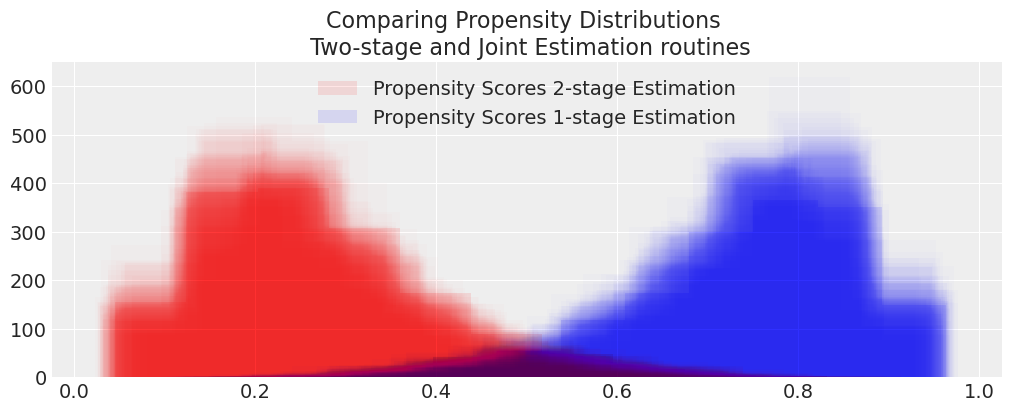

In [33]:
compare_prop_dists(idata_treatment_2s_nhefs, idata_nhefs)

### Two-Stage Outcome Modelling with CausalPy

Next we show how to achieve these steps with the simpler CausalPy experiment API. 

In [34]:
formula = """trt ~ 1 + age + race + sex + smokeintensity + smokeyrs + wt71 + active_1 + active_2 + 
         education_2 + education_3 + education_4 + education_5 + exercise_1 + exercise_2"""

df_standardised = (df - df.mean(axis=0)) / df.std(axis=0)
df_standardised["trt"] = df["trt"]
df_standardised["outcome"] = df["outcome"]
result = cp.InversePropensityWeighting(
    df_standardised,
    formula=formula,
    outcome_variable="outcome",
    weighting_scheme="robust",  ## Will be used by plots after estimation if no other scheme is specified.
    model=cp.pymc_models.PropensityScore(
        sample_kwargs={
            "chains": 4,
            "tune": 2000,
            "draws": 2000,
            "target_accept": 0.95,
            "random_seed": 18,
            "progressbar": False,
            "mp_ctx": "spawn",
        },
    ),
)

result

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 14 seconds.
Sampling: [beta_std, t_pred]
Sampling: [t_pred]


### Comparing Inverse Propensity Score Weighting and Covariate Adjustment

The two step procedure doesn't jusst apply for regression adjustment methods as we've seen here, but can be used to apply inverse weighting techniques too. 

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


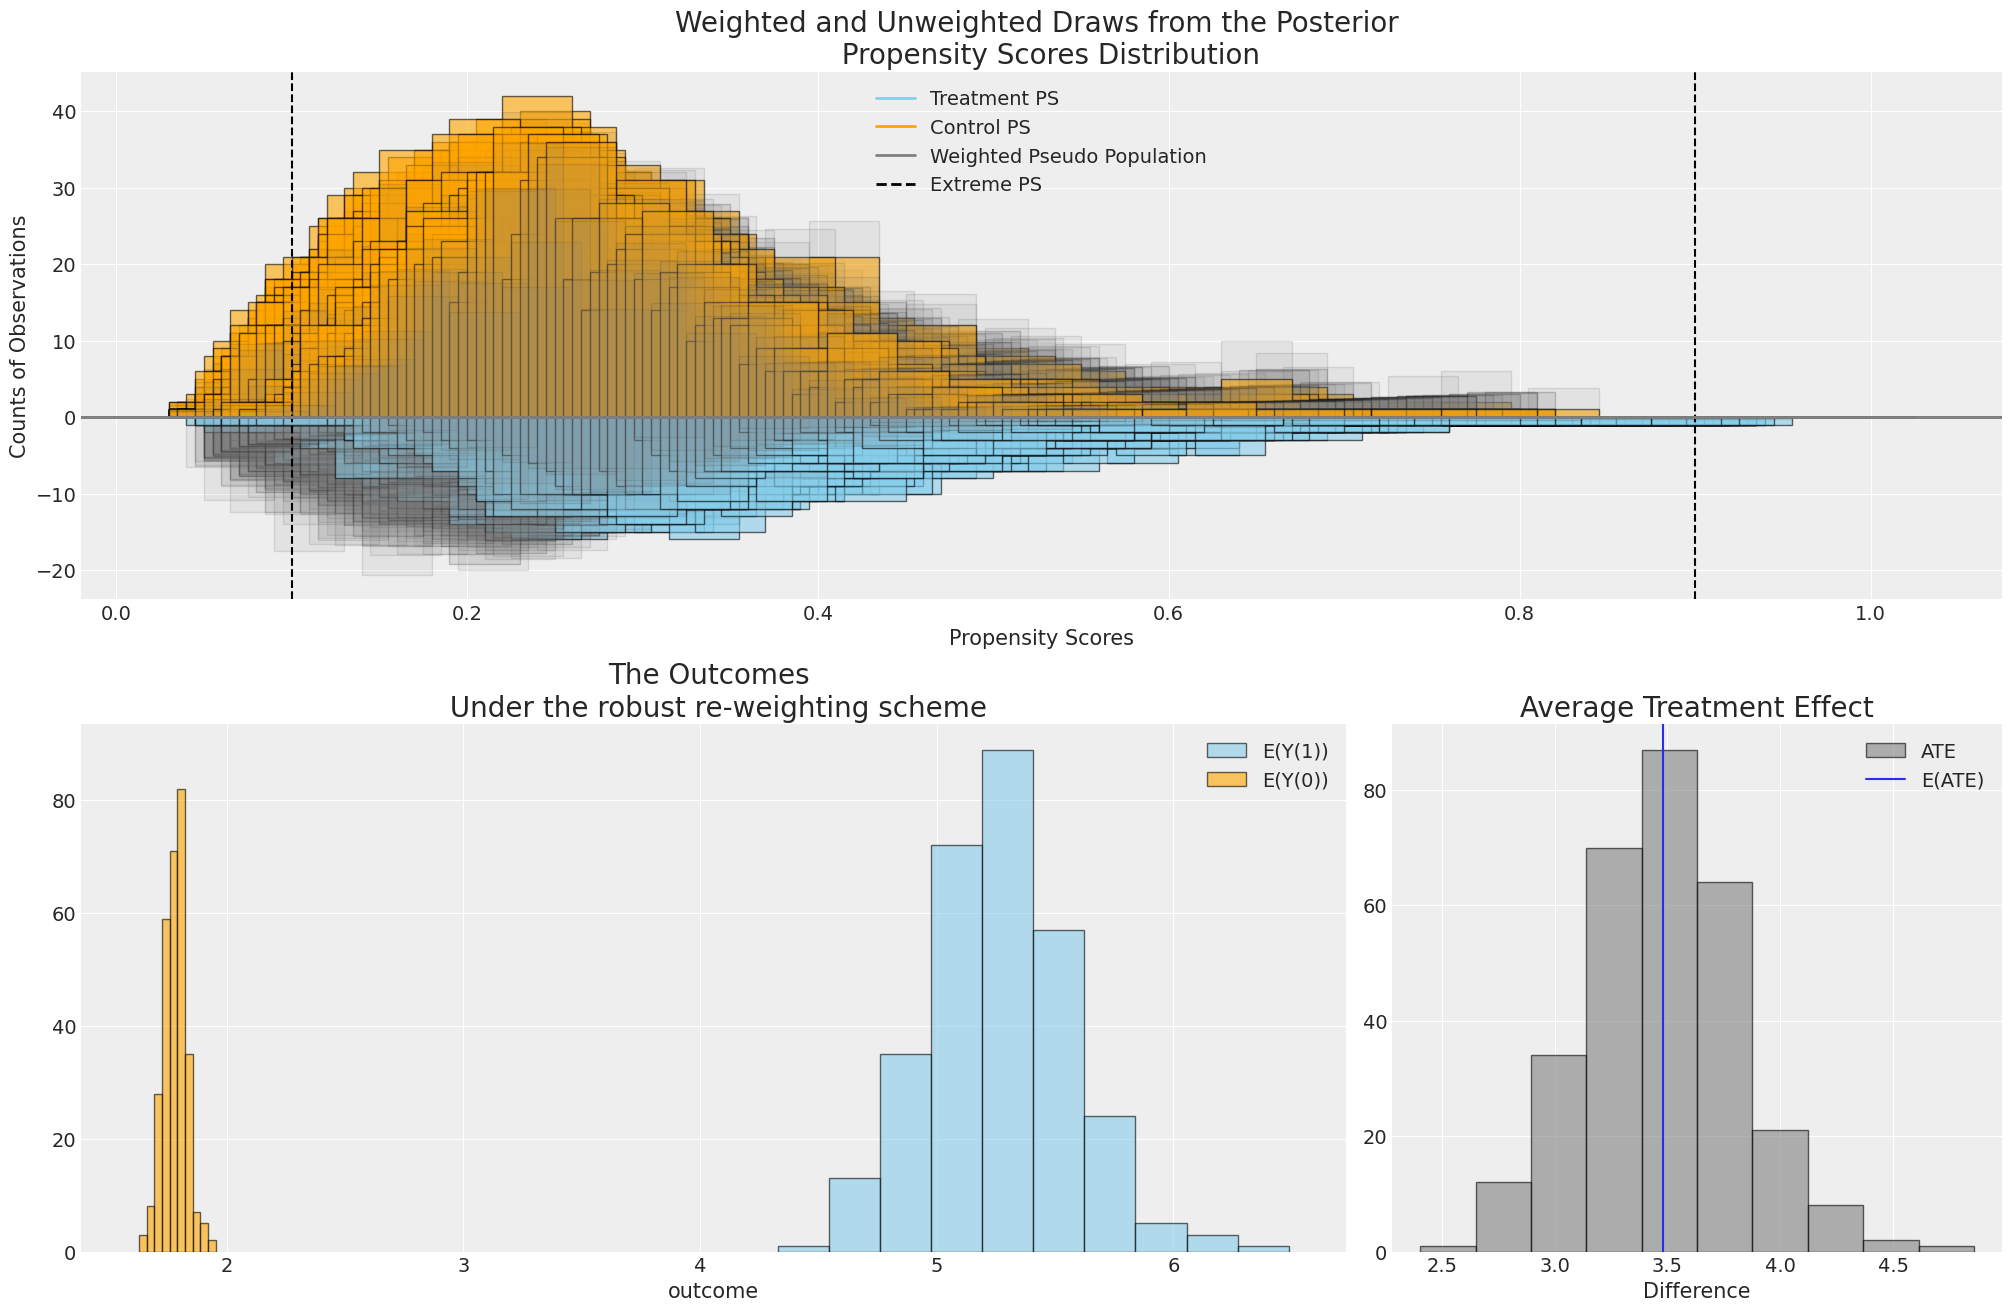

In [35]:
result.plot_ate(result.idata);

which can be compared against the two-step regression adjustment here. 

In [36]:
idata_outcome_cp, model_outcome_cp = result.model.fit_outcome_model(
    result.X_outcome,
    result.y,
    result.coords,
    priors={"b_outcome": [0, 1], "a_outcome": [0, 20], "sigma": 2},
    noncentred=True,
    normal_outcome=True,
)

Sampling: [a_outcome, beta_ps, beta_std, like, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps, a_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.


Yielding similar, but not identical results. 

In [37]:
az.summary(idata_outcome_cp, var_names=["beta_"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_[Intercept],0.024,0.979,-1.732,1.937,0.014,0.010,4766.0,5633.0,1.0
beta_[age],-2.005,0.348,-2.618,-1.315,0.005,0.003,5205.0,6095.0,1.0
beta_[race],0.159,0.204,-0.223,0.543,0.002,0.002,10079.0,6131.0,1.0
beta_[sex],-0.725,0.216,-1.125,-0.305,0.002,0.002,8236.0,6838.0,1.0
beta_[smokeintensity],0.215,0.204,-0.174,0.594,0.002,0.002,8273.0,5751.0,1.0
beta_[smokeyrs],0.276,0.351,-0.380,0.930,0.005,0.004,5290.0,6061.0,1.0
beta_[wt71],-1.449,0.204,-1.852,-1.077,0.002,0.002,10481.0,6604.0,1.0
beta_[active_1],-0.532,0.200,-0.912,-0.166,0.002,0.002,8236.0,5435.0,1.0
beta_[active_2],-0.109,0.201,-0.475,0.274,0.002,0.002,8038.0,5841.0,1.0
beta_[education_2],0.382,0.238,-0.064,0.825,0.003,0.002,5509.0,5720.0,1.0


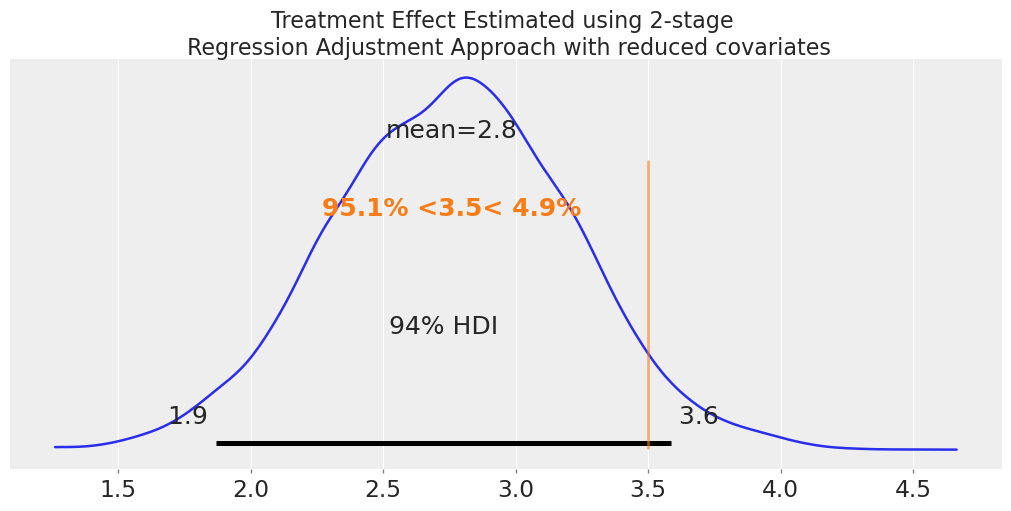

In [38]:
ax = az.plot_posterior(
    idata_outcome_cp,
    var_names=["beta_"],
    coords={"outcome_coeffs": ["trt"]},
    figsize=(10, 5),
    ref_val=3.5,
)
ax.set_title(
    "Treatment Effect Estimated using 2-stage \n Regression Adjustment Approach with reduced covariates"
);

### Conclusion: Modularity as Causal Discipline

When attempting to estimate treatment effects using Bayesian inference, a natural but risky strategy is to fit a joint model for both the treatment assignment and the outcome. That is, to specify a full model and infer the parameters of both components simultaneously.

However, this joint approach introduces a feedback loop: the outcome $Y$ can influence the estimation of the treatment mechanism $P(T | X)$. This violates the original logic of design-based inference, where treatment assignment should be modeled independently of the observed outcomes. This phenomenon is often subtle but can lead to biased treatment effect estimates.

Across several examples, we have shown that fitting a full joint model distorts the treatment effect estimate relative to a two-step (modular) approach.
In other cases, joint and modular approaches yield nearly identical estimates — usually when the treatment mechanism is well-identified from covariates alone. With these observations in scope, we recommend that practitioners generally follow a two-step or modular approach. Either two-stage inverse propensity score weighting or regression adjustment with the propensity score as an additional covariate. Both methods are available now in `CausalPy`. 

Framed this way we can see that joint model violates the temporal precedence of the treatment assignment and outcome process. The 2-stage Bayesian procedures ensure that the causal ordering encoded in the actual data generating process is respected in the estimation process. The confounding adjustment achieved with propensity score must occur without access to information about the outcome. A well-specified propensity score model can substantially improve causal estimates (as we've seen), especially when the outcome model is weak or mis-specified. This allows for a form of __doubly-robust inference__. Propensity scores do not only serve to reduce dimensionality; they formalize the treatment mechanism and encode information that the outcome model might fail to recover. This explains their continued prominence in modern causal inference and usefulness in the Bayesian setting.

### References
:::{bibliography}
:filter: docname in docnames
:::

### Watermark

In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sat Jul 12 2025

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.4.0

pytensor: 2.31.7
xarray  : 2025.7.0

pandas    : 2.3.1
matplotlib: 3.10.3
arviz     : 0.21.0
numpy     : 2.3.1
patsy     : 1.0.1
pymc      : 5.23.0
causalpy  : 0.4.2

Watermark: 2.5.0

